# Mappings between Disks and Polygons

Mappings between squares and disks have applications in computer graphics, and are interesting mathematically. Mappings between triangles and disks are less well-studied, but also interesting. Here I introduce some mappings between triangles and disks. These mappings can be compared to mappings between squares and disks, and in many cases they suggest analogous mappings between higher polygons and disks.

The mapping from the polygon to the disk is the forward mapping: the inverse from the disk to the polygon is the inverse map. All the mappings in this workbook are [homeomorphisms](https://en.wikipedia.org/wiki/Homeomorphism): i.e. the forward map is continuous, and so is the inverse map. (Another term for this is "bicontinuous.") There are other desirable qualities a mapping may have:

* [Diffeomorphism](https://en.wikipedia.org/wiki/Diffeomorphism): The forward map and inverse map are both differentiable. In terms of appearance, smooth lines stay smooth.
* Radial: Lines through the origin are preserved. If expressed in [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system) as $r, \theta$, the mapping preserves $\theta$.
* Equal-Area: Relative areas are preserved. Analytically, this means the [https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant](Jacobian) of the mapping is constant.
* [Conformal](https://en.wikipedia.org/wiki/Conformal_map): Local angles and orientation are preserved, except at the polygon vertices. All conformal mappings are diffeomorphisms.
* Mappings which preserve (proportional) distances. This isn't possible for the entire domain, but can be for certain cases, e.g. along the edges of the polygon/disk, or along lines between the vertices and the center.
* [Closed-form](https://en.wikipedia.org/wiki/Closed-form_expression): Can be expressed in terms of a finite number of defined functions and operations. This of course depends on what you accept as a defined function: here it means functions included in NumPy or SciPy.
* Simple: How simple or complicated is the formula? This is subjective and can vary between applications.

This notebook only looks at maps that preserve polygonal symmetry, because that allows one to draw analogies between the square and triangle case. So e.g. the approximate area preserving variant 2 in Reynolds 2017 isn't included, and neither are the vertical and horizontal stretches in Fong 2017. Also excluded are square maps for which an analogous triangular map hasn't yet been derived, such as the elliptical map in Nowell 2005 and some maps from Fong 2017. 

Citations (aside from the Wikipedia links sprinkled throughout):

1. [Peter Shirley, Kenneth Chiu. A Low Distortion Map Between Disk and Square. Journal of graphics tools, 2(3):45–52, 1997.](https://pdfs.semanticscholar.org/4322/6a3916a85025acbb3a58c17f6dc0756b35ac.pdf)
2. [John H. Mathews, Russell W. Howell. 11.9  The Schwarz-Christoffel Transformation, Extra Example 5. 2003.](http://mathfaculty.fullerton.edu/mathews/c2003/schwarzchristoffel/SchwarzChristoffelMod/Links/SchwarzChristoffelMod_lnk_10.html)
3. [Philip Nowell. Mapping a square to a circle. 2005.](http://mathproofs.blogspot.com/2005/07/mapping-square-to-circle.html)
4. [Chamberlain Fong. Analytical Methods for Squaring the Disc. arXiv:1509.06344, 2015.](https://arxiv.org/abs/1509.06344)
5. [Martin Lambers. Mappings between sphere, disc, and square. Journal of Computer Graphics Techniques Vol, 5(2), 2016.](http://jcgt.org/published/0005/02/01/)
6. [Marc B Reynolds. Square/Disc Mappings. 2017.](http://marc-b-reynolds.github.io/math/2017/01/08/SquareDisc.html)
7. [Chamberlain Fong. Elliptification of Rectangular Imagery. arXiv:1709.07875, 2017.](https://arxiv.org/abs/1709.07875)


In [1]:
#usual boilerplate
import numpy as np
from scipy.special import hyp2f1, gamma, ellipj, ellipk, ellipkinc
from scipy.optimize import minimize
import matplotlib.pyplot as plt
np.seterr(all='ignore')#silence div by 0 etc. warnings
eps = np.finfo(float).eps

def sqrt_safe(x):
    return np.sqrt(np.maximum(0, x))

# Standard Polygons & Disk

For consistency, all points in the plane are represented as complex numbers $z = x + i y$.

The standard disk is the unit disk $|z| \le 1$. The standard square for graphics is such that $x$ and $y$ are in $[-1, 1]$. There's no common definition of a standard triangle, but it is defined here using the third roots of unity: it is the triangle with vertices $1$, $\exp(\frac{2i \pi}{3}) = -\frac{1}{2} + i\frac{\sqrt{3}}{2}$, and $\exp(-\frac{2i \pi}{3}) = -\frac{1}{2} - i\frac{\sqrt{3}}{2}$. 

$x$ and $y$ cartesian coordinates reflect the symmetries of the square. Barycentric coordinates reflect the symmetries of the triangle, and their use can simplify triangle mappings. The barycentric coordinates of a point $z$ are $\beta_0, \beta_1, \beta_2$ such that $\beta_0 + \beta_1 + \beta_2 = 1$ and $z = z_0 \beta_0 + z_1 \beta_1 + z_2 \beta_2$. $\beta_i$ can be found from $z$ and $z_i$ by linear algebra if needed.

Other standard $n$-sided polygons can be defined using the $n$th roots of unity. However, that definition with $n=4$ is not the same as the standard square we define here: it is a rotated and scaled version of it.

In [2]:
#disk
theta = np.arange(0,24) *np.pi/12
r = np.clip(np.linspace(0,1,num=5),0,1)
std_disk = (r[:,np.newaxis] * np.exp(1j*theta)).flatten()[15:]
del theta, r

#square
square = (np.mgrid[0:11,0:11] - 5)/5
std_square = square[0] + 1j*square[1]
del square

#triangle
b = (np.mgrid[0:13,0:13]/12).reshape([2,-1])
b3 = 1 - np.sum(b, axis=0)
index = b3 >= -0.01
bary = np.vstack([b[0][index],b[1][index],b3[index]]) #shape 3, ...
tri_pts = np.exp(2j*np.pi/3*np.arange(3))
def b2t(bary, triangle=tri_pts):
    return triangle @ bary
std_tri = b2t(bary)
del b, b3, index

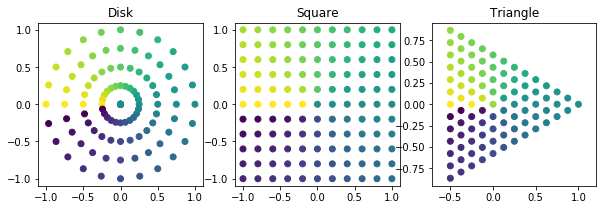

In [3]:
plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.title('Disk')
plt.axis('equal')
plt.scatter(std_disk.real, std_disk.imag, c=np.angle(std_disk))
plt.subplot(1, 3, 2)
plt.title('Square')
plt.axis('equal')
plt.scatter(std_square.real, std_square.imag, c=np.angle(std_square))
plt.subplot(1, 3, 3)
plt.title('Triangle')
plt.axis('equal')
plt.scatter(std_tri.real, std_tri.imag, c=np.angle(std_tri))
plt.show()

# Conformal

This is perhaps the mapping with the longest history. Due to the theory of complex analysis, conformal maps are best expressed in terms of complex functions. The [Schwarz-Christoffel mapping](https://en.wikipedia.org/wiki/Schwarz%E2%80%93Christoffel_mapping) gives a mapping from the upper half-plane to a simple polygon. A map from the unit disk to the upper half-plane is just a [
Möbius transformation](https://en.wikipedia.org/wiki/M%C3%B6bius_transformation). The hard part is solving the integral in the Schwarz-Christoffel mapping, which usually results in formula involving special functions.

The formulas for the conformal map from the square to the disk and its inverse are lengthy: see Lambers 2016. It involves the [Jacobi elliptic functions](https://en.wikipedia.org/wiki/Jacobi_elliptic_functions) for the forward mapping and the [Elliptic integral](https://en.wikipedia.org/wiki/Elliptic_integral) for the inverse mapping. Most numerical software packages (including SciPy) only implement these functions for real numbers, so a work-around has to be used to apply these mappings to complex numbers.

The formula for the conformal map from the disk to the triangle is shorter to write but no less complicated. 

$$ 
  z_h = \frac{z_{uv}+1}{z_{uv}-1}, \,
  z_{xy} = -
  \frac{3}{\sqrt{\pi}}
  \frac{ \Gamma\left({5/6}\right) }
  { \Gamma\left({1/3}\right) }
  z_h\, {}_2 F_1 \left(1/2,2/3;3/2; -3 z_h^2\right)
  -\frac{1}{2}
$$

$z_{uv}$ is a point on the disk, $z_h$ is a point on the (right) half-plane, and $z_{xy}$ is a point on the triangle. $\Gamma(x)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function), and ${}_2 F_1 \left(a,b;c; z\right)$ is the [hypergeometric function](https://en.wikipedia.org/wiki/Hypergeometric_function). This is rotated, translated, scaled, and simplified from the formula in Mathews et al. 2003. Fortunately, SciPy does implement the hypergeometric function for complex values. Unfortunately, a closed-form inverse of the hypergeometric function in general is not known, so a numerical inversion is used here.

In [4]:
k = ellipk(1/2)

def d2s_conf(z):
    """Conformal map, disk to square"""
    diskp = z*(1+1j)/np.sqrt(2)
    up = diskp.real
    vp = diskp.imag
    A = up**2 + vp**2
    B = up**2 - vp**2
    T = np.sqrt((1+A**2)**2 - 4*B**2)
    U = 1 + 2*B - A**2
    alpha = np.arccos(np.clip((2*A-T)/U, -1, 1))
    beta = np.arccos(np.clip(U/(2*A+T), -1, 1))
    xp = np.sign(up)*(2*k - ellipkinc(alpha, 1/2))
    yp = np.sign(vp)*ellipkinc(beta, 1/2)
    return (xp + 1j*yp)*(1-1j)/2/k

conf_sq = d2s_conf(std_disk)

#square to disk
def complexcn(z):
    """Jacobi elliptical function cn with parameter 1/2, valid for all complex numbers."""
    x = z.real
    y = z.imag
    snx, cnx, dnx, phx = ellipj(x, 1/2) 
    sny, cny, dny, phy = ellipj(y, 1/2) 
    numer = cnx * cny - 1j * snx * dnx * sny * dny
    denom = (1 - dnx**2 * sny**2)
    return numer / denom
    
def s2d_conf(z):
    csp = z * (1+1j)/2
    w = complexcn(k*(1-csp))    
    return w * (1 - 1j)/np.sqrt(2)
conf_sqdisk = s2d_conf(std_square)

In [5]:
#disk to triangle

def d2t_conf(z, scale=1-eps):
    #shrink disk by (1-eps) to avoid numerical instability along branch cuts of hyp2f1
    std_disk = scale*z
    hp1 = (std_disk+1)/(std_disk-1)
    return (-3*gamma(5/6)/gamma(1/3)/np.sqrt(np.pi)*hp1*hyp2f1(1/2, 2/3, 3/2, -3*hp1**2) ) -1/2
conf_tri = d2t_conf(std_disk)

In [6]:
conf_tridisk = std_tri.copy()
for i in range(len(std_tri)):
    z = std_tri[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        return abs(d2t_conf(t.view(dtype=np.complex128)) - z)
    res = minimize(objective, x0=xy, method='Nelder-Mead')
    conf_tridisk[i] = res.x.view(dtype=np.complex128)

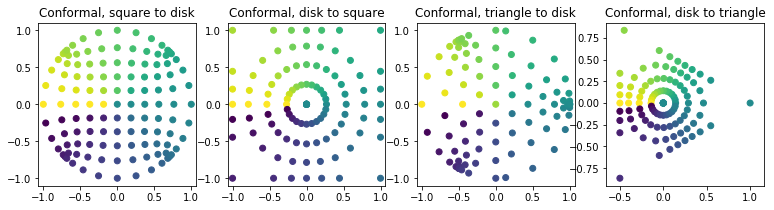

In [7]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Conformal, square to disk')
plt.axis('equal')
plt.scatter(conf_sqdisk.real, conf_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Conformal, disk to square')
plt.axis('equal')
plt.scatter(conf_sq.real, conf_sq.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Conformal, triangle to disk')
plt.axis('equal')
plt.scatter(conf_tridisk.real, conf_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Conformal, disk to triangle')
plt.axis('equal')
plt.scatter(conf_tri.real, conf_tri.imag, c=np.angle(std_disk))

plt.show()

# Radial Stretch

These are perhaps the simplest mappings. In polar form, $r$ is simply multiplied by a value depending on $\theta$.

Square:

$$
  z_{uv} = \frac{\max(|x|,|y|)}{|z_{xy}|}z_{xy},\, 
  z_{xy} = \frac{|z_{uv}|}{\max(u,v)}z_{uv} 
$$

The triangle mapping is more easily expressed in polar form:

$$
r_{uv} = 1 - 3 \min {\beta_i},\,
r_{xy} = \frac{r_{uv}}{2\cos\left(\mathrm{mod}\left(\theta,\frac{2\pi}{3}\right) - \frac{\pi}{3}\right)}
$$

Because of the presence of $\min$ and $\max$, this mapping is not a diffeomorphism.

In [8]:
#square
def s2d_radial(z):
    sfactor = np.maximum(abs(z.real),abs(z.imag))/abs(z)
    sfactor[np.isnan(sfactor)] = 1 
    return sfactor*z

rs_sqdisk = s2d_radial(std_square)

def d2s_radial(z):    
    dfactor = abs(z)/np.maximum(abs(z.real),abs(z.imag))
    dfactor[np.isnan(dfactor)] = 1 
    return dfactor*z

rs_square = d2s_radial(std_disk)

In [9]:
#triangle
def t2d_radial(bary):
    tri = b2t(bary)
    c = np.angle(tri)
    r = 1 - 3*np.min(bary, axis=0)
    return r * np.exp(1j*c)

rs_tridisk = t2d_radial(bary)

def d2t_radial(z):    
    c = np.angle(z)
    r = abs(z)/(2*np.cos(c % (np.pi*2/3) - np.pi/3))
    return r * np.exp(1j*c)
rs_tri = d2t_radial(std_disk)

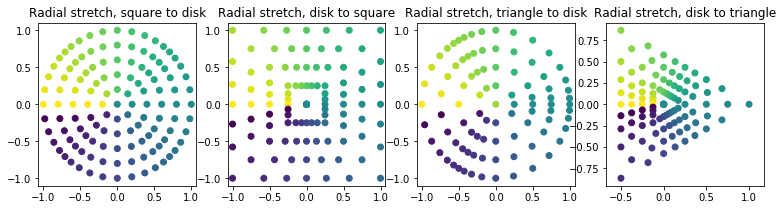

In [10]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Radial stretch, square to disk')
plt.axis('equal')
plt.scatter(rs_sqdisk.real, rs_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Radial stretch, disk to square')
plt.axis('equal')
plt.scatter(rs_square.real, rs_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Radial stretch, triangle to disk')
plt.axis('equal')
plt.scatter(rs_tridisk.real, rs_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Radial stretch, disk to triangle')
plt.axis('equal')
plt.scatter(rs_tri.real, rs_tri.imag, c=np.angle(std_disk))

plt.show()

# Concentric Equal-Area

The square mapping comes from Shirley et al. 1997, although the simplified form from Reynolds 2017 is used here. These mappings are best expressed as different cases for different segments of the polygon, and thus are not diffeomorphisms. However, it does preserve relative distances along the edges.

In [11]:
#square
def s2d_ea(z):
    x = z.real
    y = z.imag
    ea_sqdisk = np.where(abs(x) >= abs(y),
                     x*np.exp(1j*np.pi/4*y/x),
                     1j*y*np.exp(-1j*np.pi/4*x/y))
    ea_sqdisk[np.isnan(ea_sqdisk)] = 0 
    return ea_sqdisk
ea_sqdisk = s2d_ea(std_square)

def d2s_ea(z):
    u = z.real
    v = z.imag
    ea_square = np.where(abs(u) >= abs(v),
                np.sign(u)*abs(z)*(1 + 4j/np.pi*np.arctan(v/u)),
                np.sign(v)*abs(z)*(4/np.pi*np.arctan(u/v) + 1j))                
    ea_square[np.isnan(ea_square)] = 0 
    return ea_square
ea_square = d2s_ea(std_disk)

In [12]:
#triangle
def b2d_ea(bary):
    eatri0 = (3*bary[0]-1)*np.exp(1j*np.pi/3 * (bary[1] - bary[2])/(3*bary[0]-1)) 
    eatri1 = (3*bary[1]-1)*np.exp(1j*np.pi/3 * ((bary[2] - bary[0])/(3*bary[1]-1) + 2) )
    eatri2 = (3*bary[2]-1)*np.exp(1j*np.pi/3 * ((bary[0] - bary[1])/(3*bary[2]-1) - 2) )

    mb = np.min(bary, axis=0)

    ea_tridisk = eatri0.copy()
    ea_tridisk[bary[1] == mb] = eatri1[bary[1] == mb]
    ea_tridisk[bary[2] == mb] = eatri2[bary[2] == mb]
    ea_tridisk[np.isnan(ea_tridisk)] = 0 
    return ea_tridisk
ea_tridisk = b2d_ea(bary)

def d2b_ea(z):
    ea_beta = np.zeros((3,len(z)))
    for i in range(3):
        this_disk = z * np.exp(i*np.pi*2j/3)
        mask = abs(np.angle(this_disk)) >= 2/3*np.pi
        uz = this_disk.real
        vz = this_disk.imag
        absz = abs(this_disk)
        beta0 = (1 - absz)/3
        b = 6/np.pi*absz*np.arctan(vz/(absz-uz))
        beta1 = b/2 - beta0/2 + 1/2
        beta2 = -b/2 - beta0/2 + 1/2
        ea_b = np.roll(np.vstack([beta0, beta1, beta2]),-i,axis=0)
        ea_beta[:,mask] = ea_b[:,mask]
    ea_beta[:,abs(z) < eps] = 1/3
    return ea_beta

beta_ea = d2b_ea(std_disk)
ea_tri = b2t(beta_ea)


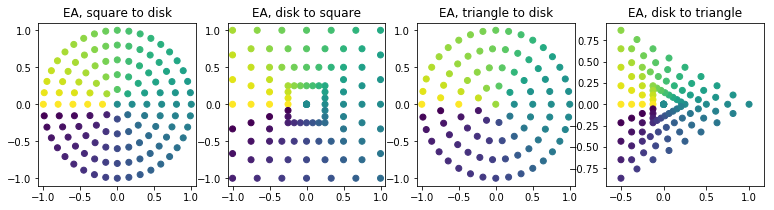

In [13]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('EA, square to disk')
plt.axis('equal')
plt.scatter(ea_sqdisk.real, ea_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('EA, disk to square')
plt.axis('equal')
plt.scatter(ea_square.real, ea_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('EA, triangle to disk')
plt.axis('equal')
plt.scatter(ea_tridisk.real, ea_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('EA, disk to triangle')
plt.axis('equal')
plt.scatter(ea_tri.real, ea_tri.imag, c=np.angle(std_disk))
plt.show()

# Approx Equal-Area

From Reynolds 2017, an approximation of the concentric equal-area mappings.

In [14]:
#square
def s2d_aea(z):
    x = z.real
    y = z.imag
    aea_sqdisk = np.where(abs(x) >= abs(y),
                  x*np.sqrt(1-y**2/2/x**2) + 1j*y/np.sqrt(2),
                  x/np.sqrt(2) + 1j*y*np.sqrt(1-x**2/2/y**2) )
    aea_sqdisk[np.isnan(aea_sqdisk)] = 0 
    return aea_sqdisk
aea_sqdisk = s2d_aea(std_square)

def d2s_aea(z):
    u = z.real
    v = z.imag    
    aea_square = np.where(abs(u) >= abs(v),
                np.sign(u)*abs(std_disk) + 1j*np.sqrt(2)*v,
                np.sqrt(2)*u + 1j*np.sign(v)*abs(std_disk))                
    aea_square[np.isnan(aea_square)] = 0 
    return aea_square
aea_square = d2s_aea(std_disk)

In [15]:
#triangle
def b2d_aea(bary):
    aeatri0 = (3*bary[0]-1)*sqrt_safe(1- ((bary[1] - bary[2])/(3*bary[0]-1))**2*3/4) + 1j*np.sqrt(3)/2*(bary[1] - bary[2])
    aeatri1 = (3*bary[1]-1)*sqrt_safe(1- ((bary[2] - bary[0])/(3*bary[1]-1))**2*3/4) + 1j*np.sqrt(3)/2*(bary[2] - bary[0])
    aeatri2 = (3*bary[2]-1)*sqrt_safe(1- ((bary[0] - bary[1])/(3*bary[2]-1))**2*3/4) + 1j*np.sqrt(3)/2*(bary[0] - bary[1])

    mb = np.min(bary, axis=0)

    aea_tridisk = aeatri0.copy()
    aea_tridisk[bary[1] == mb] = aeatri1[bary[1] == mb]*np.exp(2j*np.pi/3)
    aea_tridisk[bary[2] == mb] = aeatri2[bary[2] == mb]*np.exp(-2j*np.pi/3)
    aea_tridisk[np.isnan(aea_tridisk)] = 0 
    return aea_tridisk
aea_tridisk = b2d_aea(bary)

def d2b_aea(z):
    aea_beta = np.zeros((3,len(z)))
    for i in range(3):
        this_disk = z * np.exp(i*np.pi*2j/3)
        mask = abs(np.angle(this_disk)) >= 2/3*np.pi
        #uz = this_disk.real
        vz = this_disk.imag
        absz = abs(this_disk)
        beta0 = (1 - absz)/3
        beta1 = (2 + 2*np.sqrt(3)*vz + absz)/6
        beta2 = (2 - 2*np.sqrt(3)*vz + absz)/6        
        aea_b = np.roll(np.vstack([beta0, beta1, beta2]),-i,axis=0)
        aea_beta[:,mask] = aea_b[:,mask]
    #aea_beta[:,abs(z) < eps] = 1/3
    return aea_beta
    
beta_aea = d2b_aea(std_disk)
aea_tri = b2t(beta_aea)

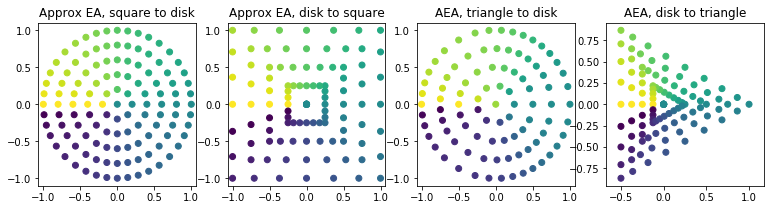

In [16]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Approx EA, square to disk')
plt.axis('equal')
plt.scatter(aea_sqdisk.real, aea_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Approx EA, disk to square')
plt.axis('equal')
plt.scatter(aea_square.real, aea_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('AEA, triangle to disk')
plt.axis('equal')
plt.scatter(aea_tridisk.real, aea_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('AEA, disk to triangle')
plt.axis('equal')
plt.scatter(aea_tri.real, aea_tri.imag, c=np.angle(std_disk))
plt.show()

# Squircle

Originating with Fong 2015. These are radial, and are also diffeomorphisms.

The inverse triangle mapping is expressible as the solution of a cubic equation. However, it has some numeric stability problems, so a numerical inversion is used instead.

In [17]:
#square
def s2d_sq(z):
    x = z.real
    y = z.imag
    sfactor = np.sqrt(x**2+y**2-x**2*y**2)/abs(z)
    sfactor[np.isnan(sfactor)] = 1 
    return sfactor*z
sr_sqdisk = s2d_sq(std_square)

def d2s_sq(z):
    u = z.real
    v = z.imag    
    n = u**2 + v**2
    s = np.sign(u*v)/np.sqrt(2) * sqrt_safe(n - sqrt_safe(n*(n-4*u**2*v**2)))
    sr_square = s * (1/v + 1j/u)
    index = (abs(z.real) < eps) | (abs(z.imag) < eps)
    sr_square[index] = z[index]
    return sr_square
sr_square = d2s_sq(std_disk)

In [18]:
#triangle
def b2d_sq(bary):
    #6 x y^2 -2 x^3 + 3 y^2 + 3 x^2
    std_tri = b2t(bary)
    sfactor = (1 - 27 * np.product(bary, axis=0))/(np.sum(bary**2, axis=0) - np.sum(bary*np.roll(bary,1,axis=0), axis=0))
    sr_tridisk = sqrt_safe(sfactor)*std_tri
    return sr_tridisk
sr_tridisk = b2d_sq(bary)

In [19]:
sr_tri_b = np.zeros([3,len(std_disk)])
for i in range(len(std_disk)):
    z = std_disk[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        t[2] = 1-t[1]-t[0]
        return abs(b2d_sq(t) - z)*1000 
    res = minimize(objective, x0=beta_aea[...,i], method='Nelder-Mead')#beta_aea[:,i]
    sr_tri_b[:,i] = res.x
    print(res.message, res.fun)
sr_tri = b2t(sr_tri_b)
res

Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 5.156136542594073e-05
Optimization terminated successfully. 8.742988482130339e-05
Optimization terminated successfully. 0.00014882280897587254
Optimization terminated successfully. 9.911860859001116e-05
Optimization terminated successfully. 0.00017713330239360324
Optimization terminated successfully. 9.911860815324229e-05
Optimization terminated successfully. 0.00014882281002340927
Optimization terminated successfully. 8.742988520303107e-05
Optimization terminated successfully. 5.156136597298114e-05
Optimization terminated successfully. 0.00013215057065393832
Optimization termi

 final_simplex: (array([[ 7.88675238e-01, -8.13304166e-08,  2.11324844e-01],
       [ 7.88674996e-01,  8.03185044e-08,  2.11324924e-01],
       [ 7.88674978e-01,  1.84194308e-08,  2.11325004e-01],
       [ 7.88675062e-01,  1.05545262e-07,  2.11324832e-01]]), array([0.00018351, 0.00018744, 0.0002316 , 0.00026822]))
           fun: 0.00018351281277954447
       message: 'Optimization terminated successfully.'
          nfev: 175
           nit: 93
        status: 0
       success: True
             x: array([ 7.88675238e-01, -8.13304166e-08,  2.11324844e-01])

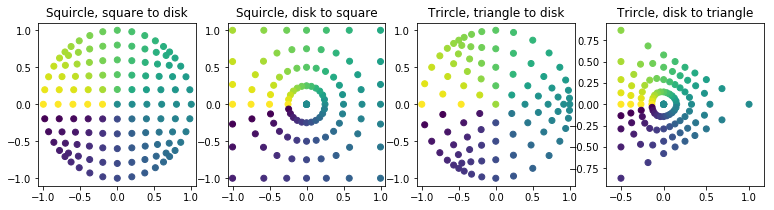

In [20]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Squircle, square to disk')
plt.axis('equal')
plt.scatter(sr_sqdisk.real, sr_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Squircle, disk to square')
plt.axis('equal')
plt.scatter(sr_square.real, sr_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Trircle, triangle to disk')
plt.axis('equal')
plt.scatter(sr_tridisk.real, sr_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Trircle, disk to triangle')
plt.axis('equal')
plt.scatter(sr_tri.real, sr_tri.imag, c=np.angle(std_disk))
plt.show()

# Naive Slerp

An original mapping, based on the naive slerp methods developed for the [the gco program in antitile](https://antitile.readthedocs.io/en/latest/gco-spherical.html#naive-slerp). These are diffeomorphisms and preserve distances along edges. The triangular form does not have a closed-form inverse so a numerical inverse is used.

In [21]:
#square
def s2d_ns(z):
    x = z.real
    y = z.imag    
    return np.sqrt(2)*(np.sin(np.pi/4*x)*np.cos(np.pi/4*y) + 1j*np.cos(np.pi/4*x)*np.sin(np.pi/4*y))
ns_sqdisk = s2d_ns(std_square)

def d2s_ns(z):
    us = z.real**2
    vs = z.imag**2 
    return (np.sign(z.real)*np.arccos(sqrt_safe(2-us+vs+sqrt_safe((vs-us+2)**2 - 8 * vs))/2)
            + 1j*np.sign(z.imag)*np.arccos(sqrt_safe(2+us-vs+sqrt_safe((vs-us+2)**2 - 8 * vs))/2) )*4/np.pi
ns_square = d2s_ns(std_disk)

In [22]:
#triangle

#tri = tri_pts @ np.sin(2*np.pi/3*bary) * 2 / np.sqrt(3)
#ns_tridisk = tri[0] + 1j*tri[1]

def b2d_ns(bary):
    return ( (2*np.sin(np.pi*2/3*bary[0])-np.sin(np.pi*2/3*bary[1])-np.sin(np.pi*2/3*bary[2]))/np.sqrt(3) 
               + 1j*(np.sin(np.pi*2/3*bary[1])-np.sin(np.pi*2/3*bary[2])) )
ns_tridisk = b2d_ns(bary)

In [23]:
ns_tri_b = np.zeros([3,len(std_disk)])
for i in range(len(std_disk)):
    z = std_disk[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        t[2] = 1-t[1]-t[0]
        return abs(b2d_ns(t) - z)*1000 
    res = minimize(objective, x0=beta_aea[...,i], method='Nelder-Mead')#beta_aea[:,i]
    ns_tri_b[:,i] = res.x
    print(res.message, res.fun)
ns_tri = b2t(ns_tri_b)
res

Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 1.2819751242557094e-13
Optimization terminated successfully. 0.00011569151422341923
Optimization terminated successfully. 0.00014970669000114657
Optimization terminated successfully. 0.0001437561652852702
Optimization terminated successfully. 9.21421509073056e-05
Optimization terminated successfully. 0.00011590857160083452
Optimization terminated successfully. 9.214214889968085e-05
Optimization terminated successfully. 0.00014375616553675443
Optimization terminated succ

 final_simplex: (array([[ 8.75000110e-01, -6.72435575e-08,  1.24999957e-01],
       [ 8.74999897e-01,  2.25741207e-08,  1.25000080e-01],
       [ 8.75000011e-01,  2.61102491e-08,  1.24999963e-01],
       [ 8.75000232e-01, -1.00910398e-07,  1.24999869e-01]]), array([8.25027522e-05, 1.28300757e-04, 1.29627002e-04, 1.40741763e-04]))
           fun: 8.250275221672645e-05
       message: 'Optimization terminated successfully.'
          nfev: 153
           nit: 78
        status: 0
       success: True
             x: array([ 8.75000110e-01, -6.72435575e-08,  1.24999957e-01])

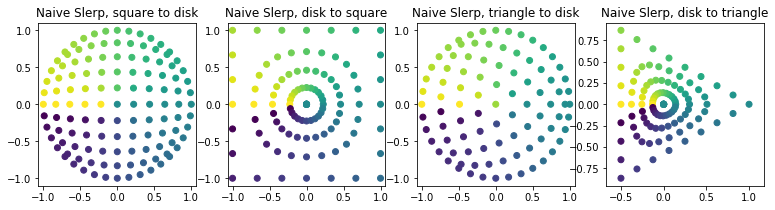

In [24]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Naive Slerp, square to disk')
plt.axis('equal')
plt.scatter(ns_sqdisk.real, ns_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Naive Slerp, disk to square')
plt.axis('equal')
plt.scatter(ns_square.real, ns_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Naive Slerp, triangle to disk')
plt.axis('equal')
plt.scatter(ns_tridisk.real, ns_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Naive Slerp, disk to triangle')
plt.axis('equal')
plt.scatter(ns_tri.real, ns_tri.imag, c=np.angle(std_disk))

plt.show()

This is a second form of square Naive Slerp. It is more complicated and lacks a closed-form inverse, but is a diffeomorphism that preserves distances along edges.

In [25]:
#square #2
def s2d_ns2(z):
    x = z.real
    y = z.imag        
    return np.sqrt(2)*(
        +np.sqrt(2+np.sqrt(2))*np.sin(np.pi/8*x)*np.cos(np.pi/8*y)*np.cos(np.pi/8*x*y)
        -np.sqrt(2-np.sqrt(2))*np.cos(np.pi/8*x)*np.sin(np.pi/8*y)*np.sin(np.pi/8*x*y)
        +1j*np.sqrt(2+np.sqrt(2))*np.cos(np.pi/8*x)*np.sin(np.pi/8*y)*np.cos(np.pi/8*x*y)
        -1j*np.sqrt(2-np.sqrt(2))*np.sin(np.pi/8*x)*np.cos(np.pi/8*y)*np.sin(np.pi/8*x*y))
ns2_sqdisk = s2d_ns2(std_square)

In [26]:
ns2_square = std_disk.copy()
#ns_tri_b = np.zeros([3,len(std_disk)])
for i in range(len(std_disk)):
    z = std_disk[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        return abs(s2d_ns2(t.view(dtype=np.complex128)) - z)*1000 
    res = minimize(objective, x0=xy, method='Nelder-Mead')
    ns2_square[i] = res.x.view(dtype=np.complex128)
    print(res.message, res.fun)
res

Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.0
Optimization terminated successfully. 0.00015317603950230508
Optimization terminated successfully. 6.036875024752728e-05
Optimization terminated successfully. 9.633269412000763e-05
Optimization terminated successfully. 0.00011342742413990195
Optimization terminated successfully. 9.633269412756022e-05
Optimization terminated successfully. 6.036875024752728e-05
Optimization terminated successfully. 0.00017264537555128356
Optimization terminated successfully. 6.0368750259414506e-05
Optimization terminated successfully. 9.63326941311605e-05
Optimization terminated successfully. 0.00011342742410492625
Optimization termi

 final_simplex: (array([[ 0.99999992, -0.33333352],
       [ 1.00000024, -0.33333345],
       [ 0.99999967, -0.33333312]]), array([0.00018822, 0.00019834, 0.00027912]))
           fun: 0.0001882175583673483
       message: 'Optimization terminated successfully.'
          nfev: 83
           nit: 44
        status: 0
       success: True
             x: array([ 0.99999992, -0.33333352])

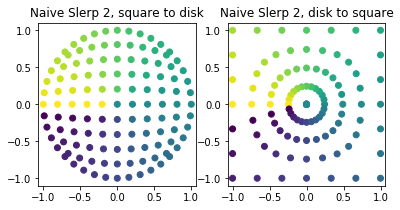

In [27]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Naive Slerp 2, square to disk')
plt.axis('equal')
plt.scatter(ns2_sqdisk.real, ns2_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Naive Slerp 2, disk to square')
plt.axis('equal')
plt.scatter(ns2_square.real, ns2_square.imag, c=np.angle(std_disk))

plt.show()